In [53]:
import pandas as pd
import matplotlib.pyplot as plt


In [63]:

# Read the JSON file
df = pd.read_json('/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/processed_posts.json')

# Function to flatten the extracted lexicon terms
def flatten_lexicon(row):
    if isinstance(row.get('extracted_lexicon'), dict):
        terms = row['extracted_lexicon'].get('terms', [])
        return pd.Series([
            [term['term'] for term in terms],
            [term['context'] for term in terms],
            [term['category'] for term in terms]
        ], index=['lexicon_terms', 'lexicon_contexts', 'lexicon_categories'])
    return pd.Series([None, None, None], index=['lexicon_terms', 'lexicon_contexts', 'lexicon_categories'])

# Function to flatten content analysis
def flatten_content_analysis(row):
    if isinstance(row.get('content_analysis'), dict):
        ca = row['content_analysis']
        return pd.Series({
            'sentiment_score': ca['sentiment']['score'],
            'sentiment_tone': ca['sentiment']['primary_tone'],
            'emotional_intensity': ca['emotional_intensity']['score'],
            'pain_level': ca['pain_level']['score'],
            'pain_confidence': ca['pain_level']['confidence'],
            'urgency_level': ca['urgency']['level'],
            'primary_topic': ca['topic_classification']['primary_topic']
        })
    return pd.Series({
        'sentiment_score': None, 'sentiment_tone': None, 'emotional_intensity': None,
        'pain_level': None, 'pain_confidence': None, 'urgency_level': None, 'primary_topic': None
    })

# Apply the flattening functions and combine with basic columns
df_processed = pd.concat([
    df[['title', 'author', 'created_timestamp', 'score', 'upvote_ratio', 'content', 'comment_count']],
    df.apply(flatten_lexicon, axis=1),
    df.apply(flatten_content_analysis, axis=1)
], axis=1)

df_processed['lexicon_string'] = df_processed['lexicon_terms'].apply(lambda x: ' '.join(x))

# Display the first few rows of the processed dataframe
df_processed.head()


,title,author,created_timestamp,score,upvote_ratio,content,comment_count,lexicon_terms,lexicon_contexts,lexicon_categories,sentiment_score,sentiment_tone,emotional_intensity,pain_level,pain_confidence,urgency_level,primary_topic,lexicon_string
0,Speech dictation is so horrible,Genkikiwi,2024-12-30T00:52:57.936000+0000,3,0,:/ i understand the application of it is likel...,1,"[my pain flares up, alienated among my friends...","[describing episodes of increased pain, expres...","[intensity, emotional, impact, intensity, inte...",-0.6,Negative,0.8,6,0.7,moderate,Support and Personal Experiences,my pain flares up alienated among my friends h...
1,One of the most frustrating comments,beepboop531,2020-04-12T16:33:47.150000+0000,675,0,,72,"[chronic pain, intense chronic pain, hip joint...",[describing ongoing pain experienced over time...,"[physical, intensity, location, temporal, impa...",-0.7,Negative,0.8,7,0.6,moderate,Support and Personal Experiences,chronic pain intense chronic pain hip joint hi...
2,Advise needed please…also a bit of a rant beca...,-MetalKitty-,2024-12-09T04:15:57.791000+0000,30,0,The doctor I had been seeing for 20 years reti...,32,[can't find a doctor that will prescribe my pa...,[struggling with access to prescribed medicati...,"[impact, emotional, emotional, emotional, phys...",-0.8,Negative,0.9,-1,0.0,high,Support and Personal Experiences,can't find a doctor that will prescribe my pai...
3,Research on Cannabis Oil for MS and Potential ...,mrcenterofdauniverse,2024-12-11T02:57:56.986000+0000,1,0,My father has multiple sclerosis and is underg...,2,"[chronic pain, interfere with his MS treatment...",[describing the ongoing pain condition experie...,"[impact, impact, impact, physical, physical, i...",-0.4,Negative,0.7,-1,0.0,moderate,Support and Personal Experiences,chronic pain interfere with his MS treatment b...
4,The incidence of addiction or overdose attendi...,RichardALawhern,2024-12-06T18:07:14.391000+0000,47,0,"For Doctors, Patients, Advocates, Lawyers, and...",19,"[pained objections, millions of people in pain...",[describing resistance met from medical boards...,"[emotional, impact, impact, emotional, impact,...",-0.5,Negative,0.7,-1,0.0,high,Support and Personal Experiences,pained objections millions of people in pain h...


Score Statistics:
count     498.000000
mean      139.528112
std       311.349184
min         0.000000
25%         2.000000
50%         7.000000
75%        69.750000
max      2335.000000
Name: score, dtype: float64

Comment Count Statistics:
count    498.000000
mean      28.453815
std       53.989705
min        0.000000
25%        3.000000
50%        9.000000
75%       30.750000
max      607.000000
Name: comment_count, dtype: float64


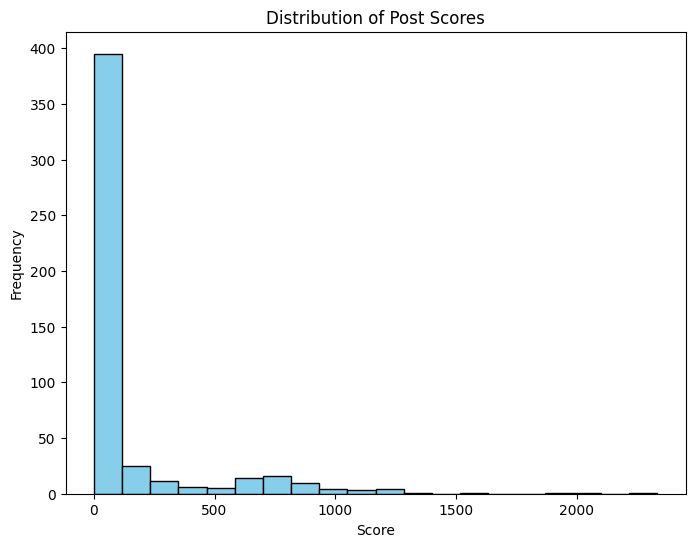

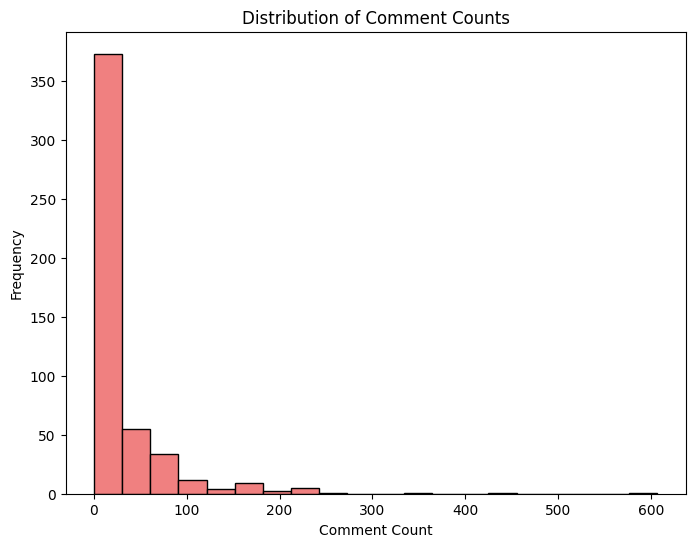

In [64]:
# analyze the reddit posts - score and comment count
print("Score Statistics:")
print(df_processed['score'].describe())
print("\nComment Count Statistics:")
print(df_processed['comment_count'].describe())

# Visualizations
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df_processed['score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_processed['comment_count'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Comment Counts')
plt.xlabel('Comment Count')
plt.ylabel('Frequency')
plt.show()


In [65]:
# number of unique lexicon_terms
all_terms = []
for terms_list in df_processed['lexicon_terms'].dropna():
    all_terms.extend(terms_list)

num_unique_terms = len(set(all_terms))
print(f"Number of unique lexicon terms: {num_unique_terms}")

Number of unique lexicon terms: 4074


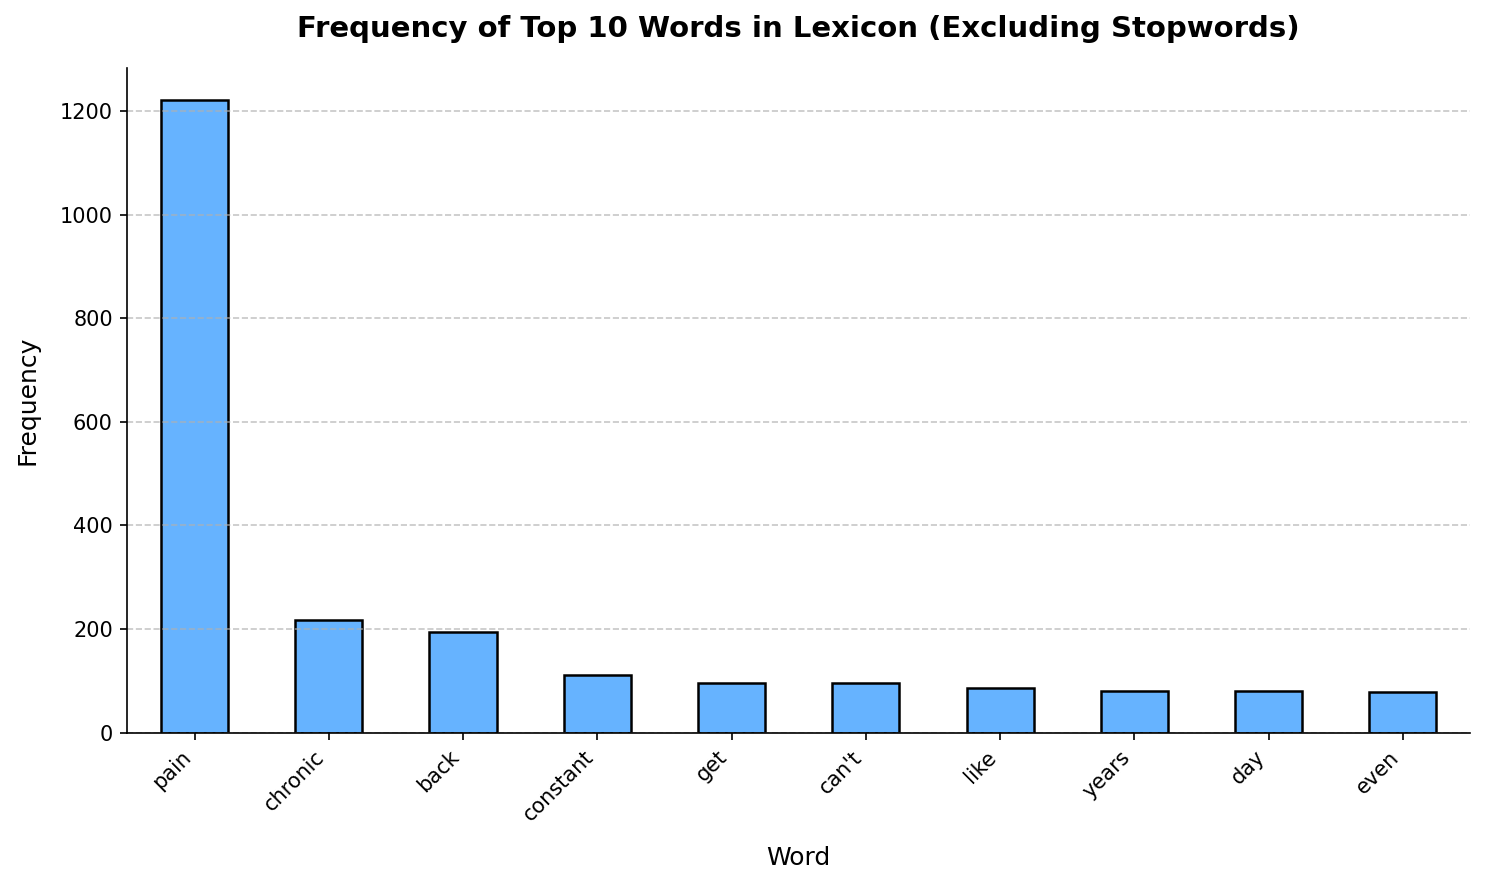

In [87]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

all_terms_string = ' '.join(all_terms)
words = all_terms_string.lower().split()
filtered_words = [word for word in words if word not in stop_words]
word_counts = pd.Series(filtered_words).value_counts()
top_10_words = word_counts.head(10)

plt.figure(figsize=(10, 6), dpi=150)
ax = top_10_words.plot(kind='bar', color='#66b3ff', edgecolor='black', linewidth=1.2)
plt.title('Frequency of Top 10 Words in Lexicon (Excluding Stopwords)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Word', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

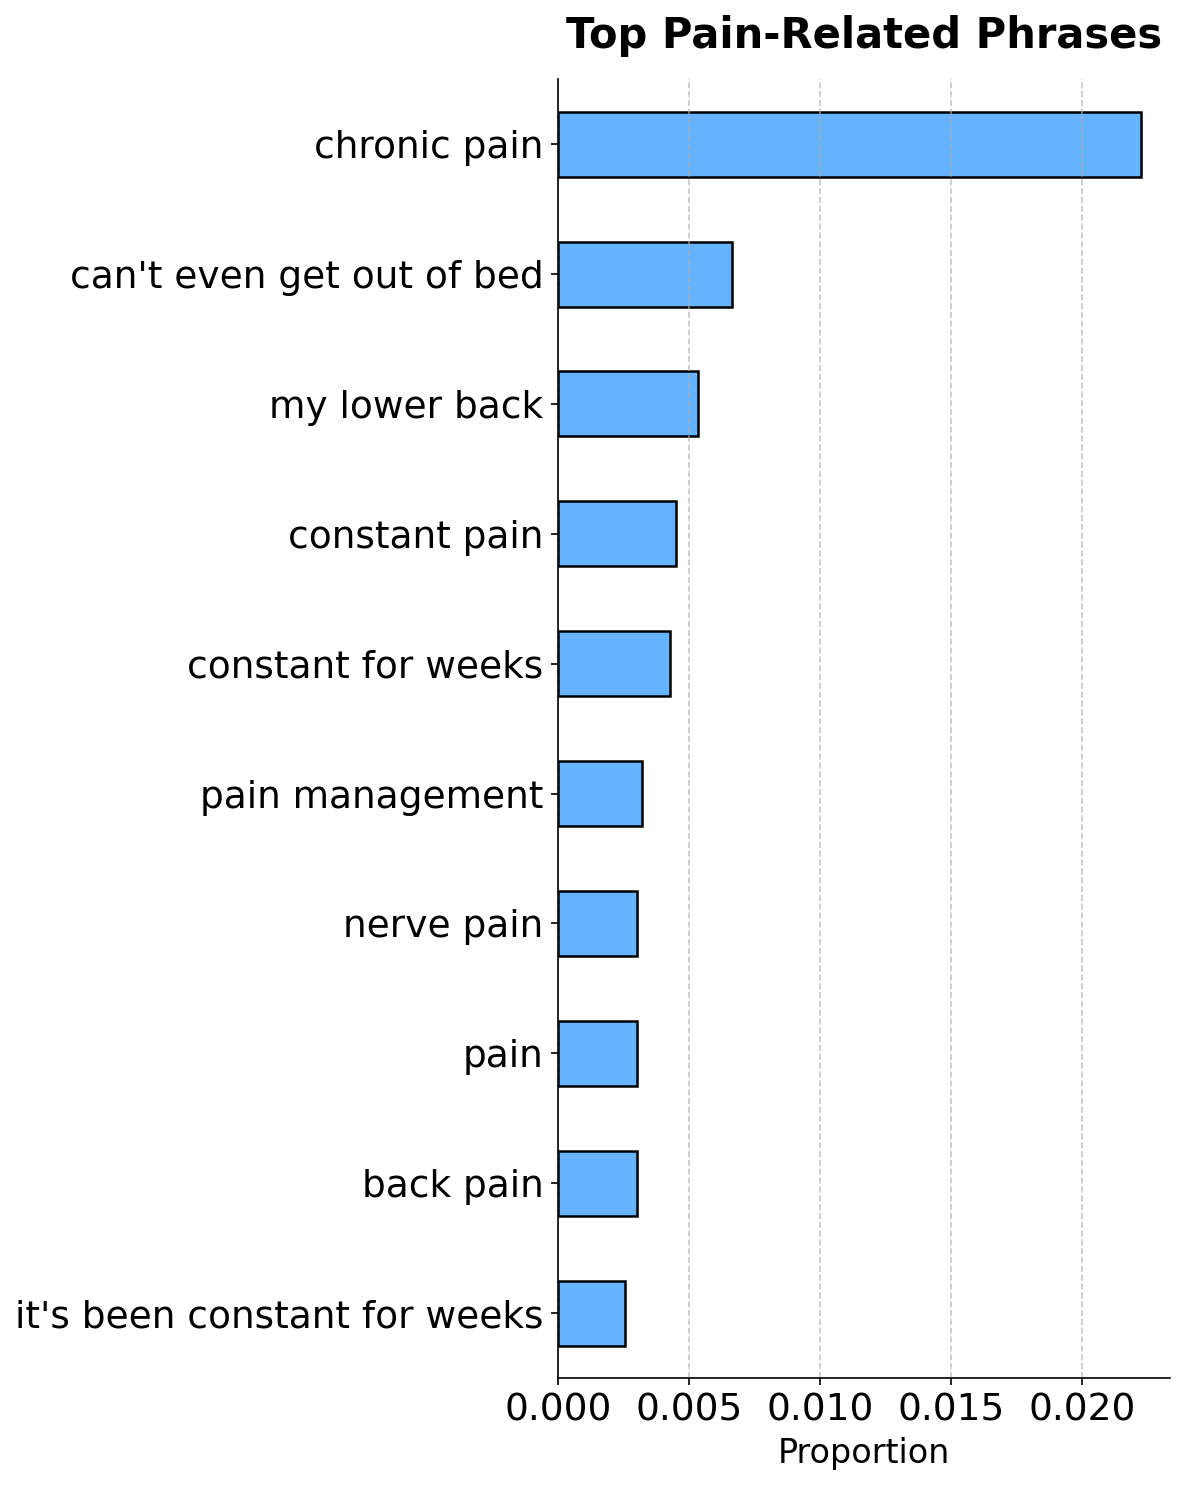

In [136]:
# proportion of terms 
term_counts = pd.Series(all_terms).value_counts()
top_10_terms = term_counts.head(10)
top_10_terms = top_10_terms.sort_values(ascending=True)

# Convert counts to proportions
top_10_proportions = top_10_terms / len(all_terms)

plt.figure(figsize=(8, 10), dpi=150)  # Increased dpi for better resolution, swapped figsize for vertical
ax = top_10_proportions.plot(kind='barh', color='#66b3ff', edgecolor='black', linewidth=1.2) # Use a more scientific color and add linewidth, changed to barh
plt.title('Top Pain-Related Phrases', fontsize=20, fontweight='bold', pad=15) # More descriptive title, bold, and padding, centered
plt.xlabel('Proportion', fontsize=16) # Label padding, swapped x and y labels
plt.yticks(fontsize=18) # Adjust font size, removed rotation
plt.xticks(fontsize=18) # Adjust font size
ax.spines['top'].set_visible(False) # Remove top spine
ax.spines['right'].set_visible(False) # Remove right spine
plt.grid(axis='x', linestyle='--', alpha=0.7) # Add a subtle grid, changed to x axis
plt.tight_layout()
plt.savefig("/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/visualizations/top_pain_related_terms_llm.png")
plt.show()

In [48]:
# perform Bertopic on the lexicon terms
from bertopic import BERTopic
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df_processed['lexicon_string'].dropna())


In [ ]:
# Get topic information and visualizations
# Print top terms per topic
topic_info = topic_model.get_topic_info()
print("Topic Information:")
print(topic_info)

# Get top terms for each topic
print("\nTop Terms per Topic:")
for topic in topic_model.get_topics():
    print(f"\nTopic {topic}:")
    print(topic_model.get_topic(topic))

# Visualize topics
# Topic hierarchy dendrogram
topic_model.visualize_hierarchy(top_n_topics=20)
plt.title("Topic Hierarchy Dendrogram")
plt.tight_layout()
plt.show()

# Visualize the topics as a network
topic_model.visualize_topics()
plt.title("Topic Network Visualization")
plt.show()

# Optional: Create an interactive visualization in your browser
# topic_model.visualize_topics().write_html("topic_visualization.html")

# Get topic similarities
topic_model.visualize_heatmap()
plt.title("Topic Similarity Heatmap")
plt.show()

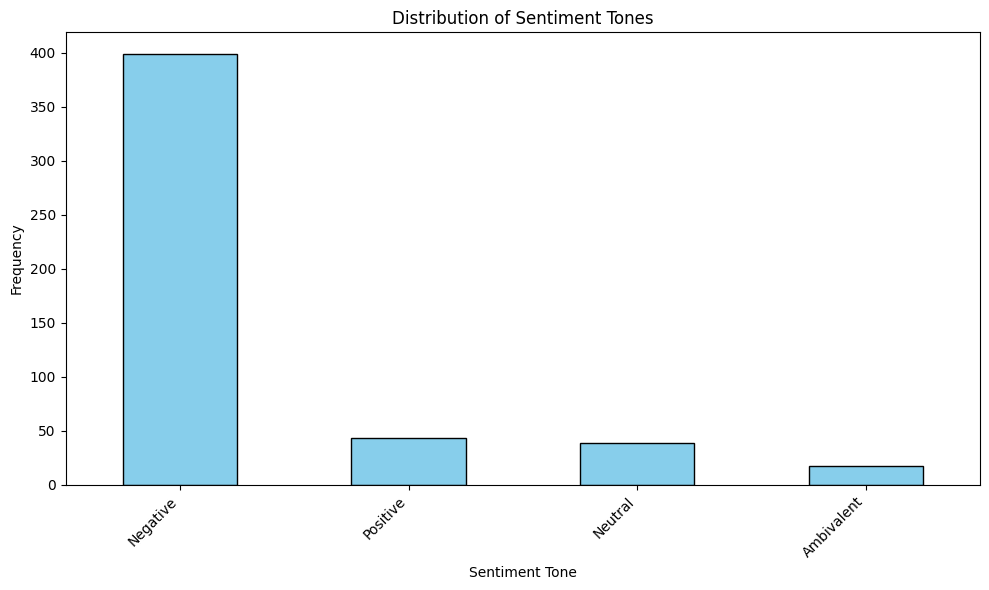

In [67]:
sentiment_counts = df_processed['sentiment_tone'].value_counts()
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Tones')
plt.xlabel('Sentiment Tone')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

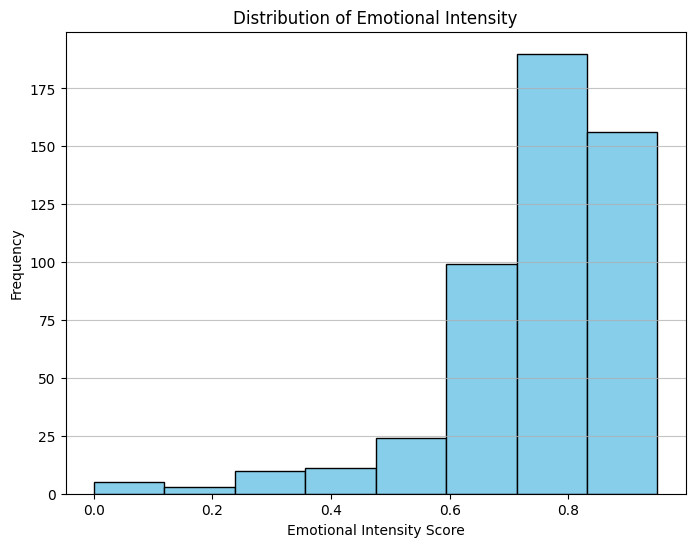

In [68]:
plt.figure(figsize=(8, 6))
plt.hist(df_processed['emotional_intensity'].dropna(), bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Emotional Intensity')
plt.xlabel('Emotional Intensity Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

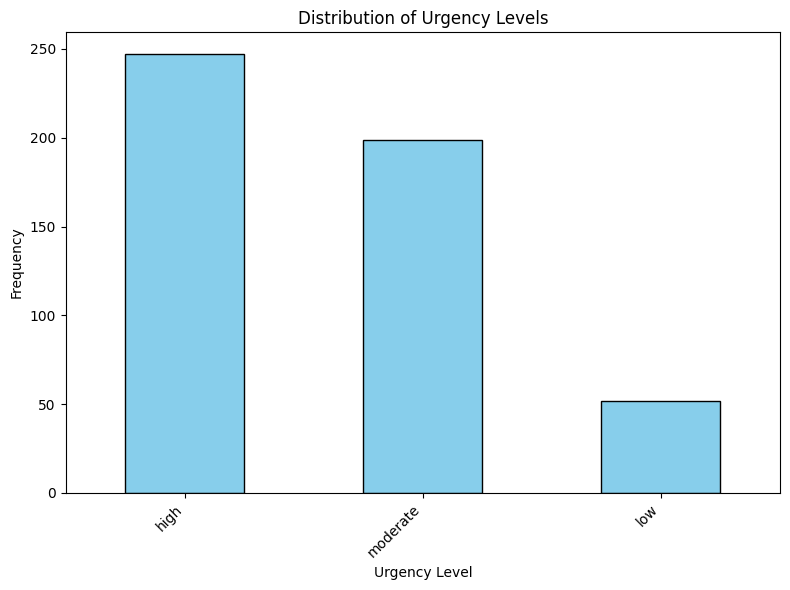

In [69]:
urgency_counts = df_processed['urgency_level'].value_counts()
plt.figure(figsize=(8, 6))
urgency_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Urgency Levels')
plt.xlabel('Urgency Level')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

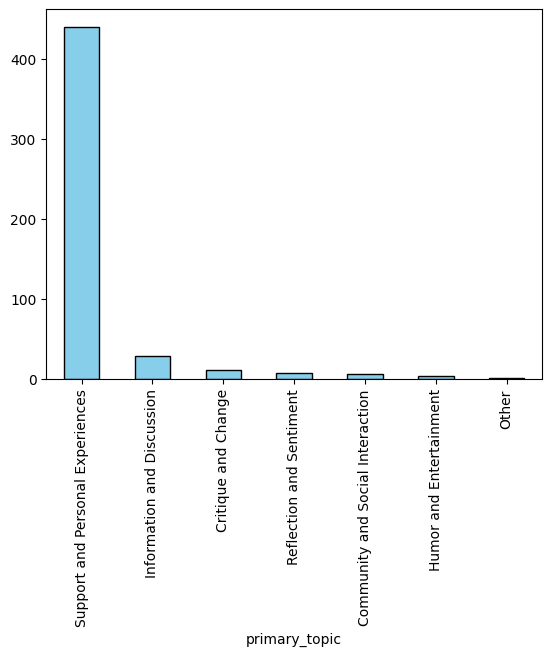

In [70]:
df_processed['primary_topic'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.show()

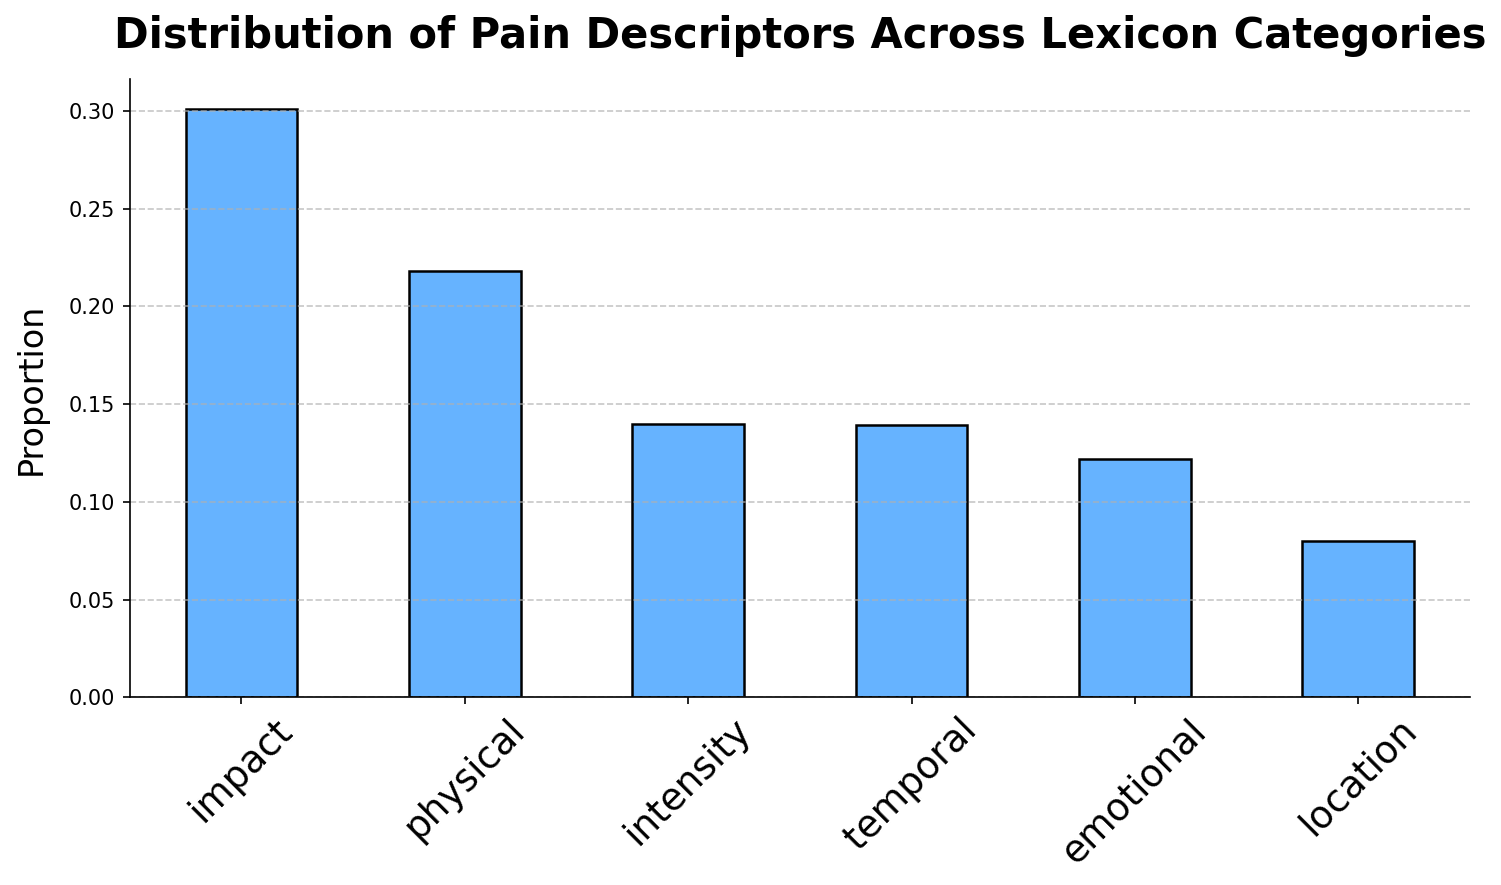


Category Proportions:
impact       0.301091
physical     0.218061
intensity    0.139953
temporal     0.139097
emotional    0.121763
location     0.080034
Name: proportion, dtype: float64


In [124]:
# Flatten the lists and count categories
category_counts = pd.Series([
    category 
    for categories in df_processed['lexicon_categories'] 
    for category in categories
])

category_proportions = category_counts.value_counts(normalize=True)

plt.figure(figsize=(10, 6), dpi=150)
ax = category_proportions.plot(kind='bar', color='#66b3ff', edgecolor='black', linewidth=1.2)
plt.title('Distribution of Pain Descriptors Across Lexicon Categories', fontsize=20, fontweight='bold', pad=15)
plt.ylabel('Proportion', fontsize=16, labelpad=10)
plt.xticks(rotation=45, ha='center', fontsize=18)
plt.yticks(fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/visualizations/lexicon_categories.png")
plt.show()

print("\nCategory Proportions:")
print(category_proportions)

In [74]:
df = pd.read_json('/Users/julienh/Desktop/McGillWork/PainLexicon/chronic_reddit_scraper/processed_posts.json')

df.head()

,title,author,created_timestamp,score,upvote_ratio,content,post_id,comments,image_url,comment_count,extracted_lexicon,content_analysis,slang_terms
0,Speech dictation is so horrible,Genkikiwi,2024-12-30T00:52:57.936000+0000,3,0,:/ i understand the application of it is likel...,t3_1hpat85,"[{'thing_id': 't1_m4ivacc', 'depth': 0, 'paren...",https://www.reddit.com/r/ChronicPain/comments/...,1,"{'terms': [{'term': 'my pain flares up', 'cont...","{'sentiment': {'score': -0.6000000000000001, '...","{'clinical_term': 'chronic pain', 'colloquial_..."
1,One of the most frustrating comments,beepboop531,2020-04-12T16:33:47.150000+0000,675,0,,t3_fzzv2w,"[{'thing_id': 't1_fn75nwm', 'depth': 0, 'paren...",https://i.redd.it/no5f5wonzes41.jpg,72,"{'terms': [{'term': 'chronic pain', 'context':...","{'sentiment': {'score': -0.7000000000000001, '...","{'clinical_term': 'Chronic Pain', 'colloquial_..."
2,Advise needed please…also a bit of a rant beca...,-MetalKitty-,2024-12-09T04:15:57.791000+0000,30,0,The doctor I had been seeing for 20 years reti...,t3_1ha1foo,"[{'thing_id': 't1_m15bbgg', 'depth': 0, 'paren...",https://www.reddit.com/r/ChronicPain/comments/...,32,{'terms': [{'term': 'can't find a doctor that ...,"{'sentiment': {'score': -0.8, 'primary_tone': ...","{'clinical_term': 'opioid dependence', 'colloq..."
3,Research on Cannabis Oil for MS and Potential ...,mrcenterofdauniverse,2024-12-11T02:57:56.986000+0000,1,0,My father has multiple sclerosis and is underg...,t3_1hbjsa5,"[{'thing_id': 't1_m1gutwb', 'depth': 0, 'paren...",https://www.reddit.com/r/ChronicPain/comments/...,2,"{'terms': [{'term': 'chronic pain', 'context':...","{'sentiment': {'score': -0.4, 'primary_tone': ...","{'clinical_term': 'multiple sclerosis', 'collo..."
4,The incidence of addiction or overdose attendi...,RichardALawhern,2024-12-06T18:07:14.391000+0000,47,0,"For Doctors, Patients, Advocates, Lawyers, and...",t3_1h87m77,"[{'thing_id': 't1_m0rjjgd', 'depth': 0, 'paren...",https://www.reddit.com/r/ChronicPain/comments/...,19,"{'terms': [{'term': 'pained objections', 'cont...","{'sentiment': {'score': -0.5, 'primary_tone': ...","{'clinical_term': 'opioid analgesics', 'colloq..."


In [79]:
# look at sample of extracted lexicon terms
all_terms[:10]

['my pain flares up',
 'alienated among my friends',
 'housebound',
 'so annoying',
 'less pain than usual',
 'chronic pain',
 'intense chronic pain',
 'hip joint',
 'high-pain day',
 "can't even get out of bed"]

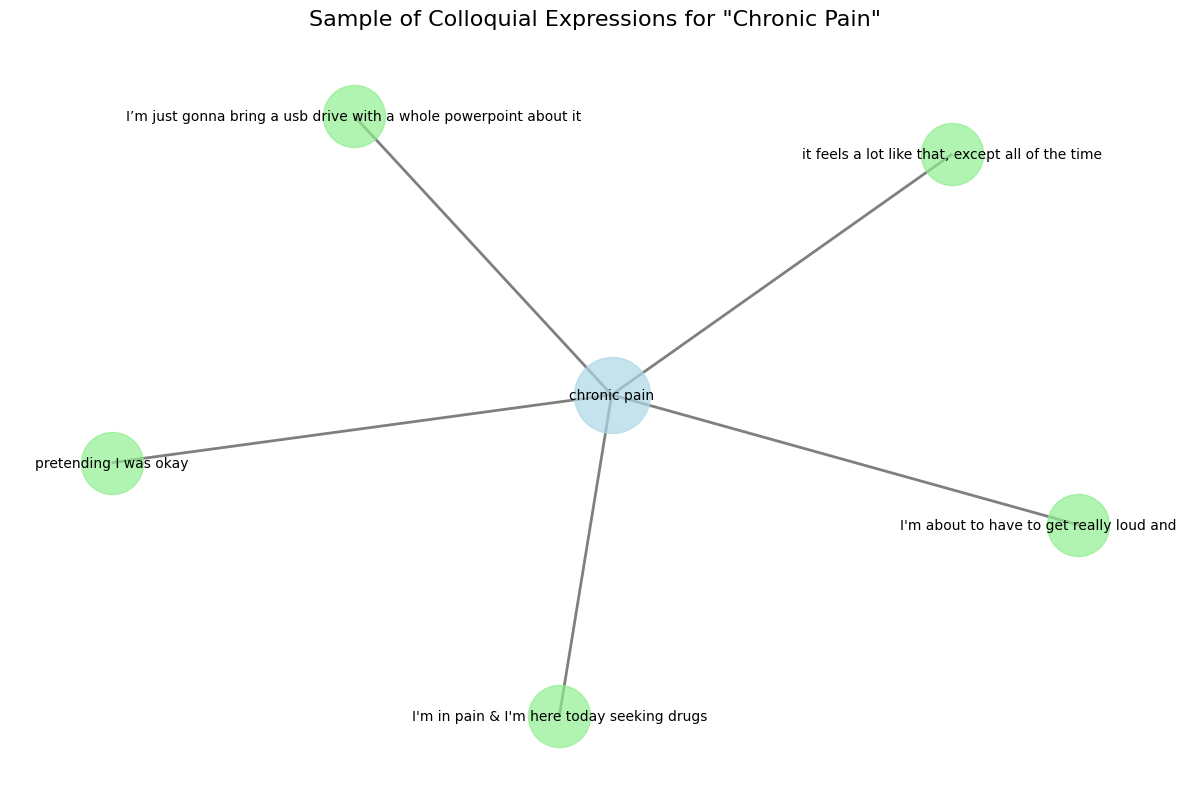


Sampled expressions for 'chronic pain':
- pretending I was okay
- I'm about to have to get really loud and aggressive
- I’m just gonna bring a usb drive with a whole powerpoint about it
- I'm in pain & I'm here today seeking drugs
- it feels a lot like that, except all of the time

Total number of expressions in dataset: 1166


In [84]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Choose a specific clinical term
target_term = 'chronic pain'

# Extract colloquial expressions for the target term
all_expressions = []
for _, row in df.iterrows():
    if isinstance(row.get('slang_terms'), dict):
        clinical_term = row['slang_terms'].get('clinical_term')
        if clinical_term and clinical_term.lower() == target_term.lower():
            colloquial_expressions = row['slang_terms'].get('colloquial_expressions', [])
            all_expressions.extend(colloquial_expressions)

# Randomly sample 5 expressions
sampled_expressions = random.sample(all_expressions, min(5, len(all_expressions)))
clinical_colloquial_pairs = [(target_term, expr) for expr in sampled_expressions]

# Create network graph
G = nx.Graph()

# Add edges between clinical term and colloquial expressions
for clinical, colloquial in clinical_colloquial_pairs:
    G.add_edge(clinical, colloquial)

# Set up the visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.9, iterations=50)

# Draw central node (clinical term)
nx.draw_networkx_nodes(G, pos,
                      nodelist=[target_term],
                      node_color='lightblue',
                      node_size=3000,
                      alpha=0.7)

# Draw colloquial expression nodes
nx.draw_networkx_nodes(G, pos,
                      nodelist=[n for n in G.nodes() if n != target_term],
                      node_color='lightgreen',
                      node_size=2000,
                      alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5, width=2)

# Add labels for all nodes
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10)


plt.title(f'Sample of Colloquial Expressions for "{target_term.title()}"', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print statistics and sampled expressions
print(f"\nSampled expressions for '{target_term}':")
for expr in sampled_expressions:
    print(f"- {expr}")
print(f"\nTotal number of expressions in dataset: {len(all_expressions)}")